No CSV found at /mnt/data/ecommerce_data.csv — creating synthetic dataset (2 years daily)
Synthetic dataset created with 730 rows and saved to \mnt\data\ecommerce_festival_analysis\synthetic_ecommerce_data.csv
        date  visitors  orders    revenue      aov top_category  is_festival  \
0 2023-11-20      9100     163  234211.75  1436.88  electronics        False   
1 2023-11-21      9343     157  176032.25  1121.22         home        False   
2 2023-11-22      7375     109  115953.81  1063.80      fashion        False   
3 2023-11-23      7653     134  172814.18  1289.66  electronics        False   
4 2023-11-24      7889     129  143177.64  1109.90         home        False   
5 2023-11-25     15058     460  669843.81  1456.18         home         True   
6 2023-11-26     16061     559  651803.06  1166.02  electronics         True   
7 2023-11-27     14451     398  453052.58  1138.32         home         True   

         cr  rev_per_visitor  
0  0.017912        25.737555  
1  0.01

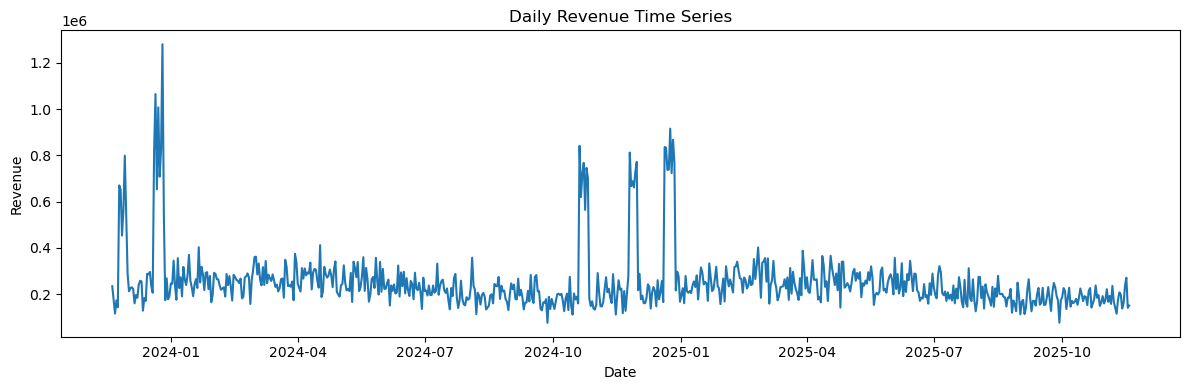

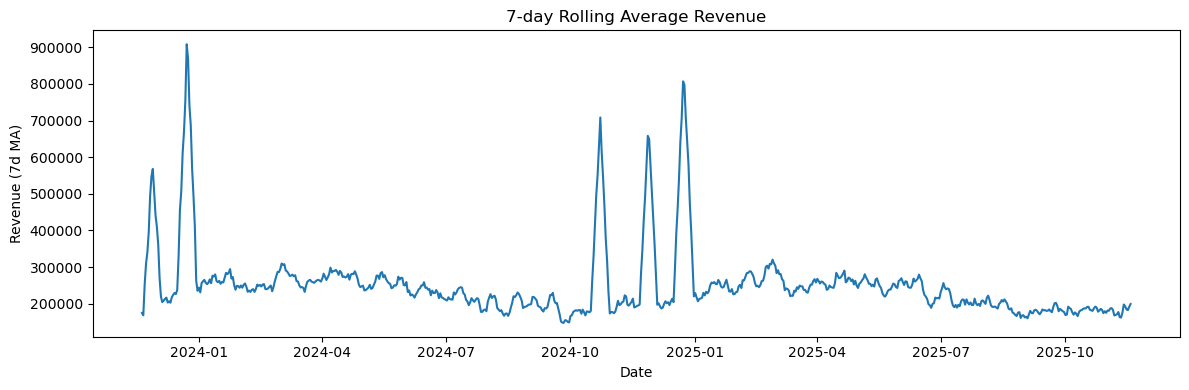

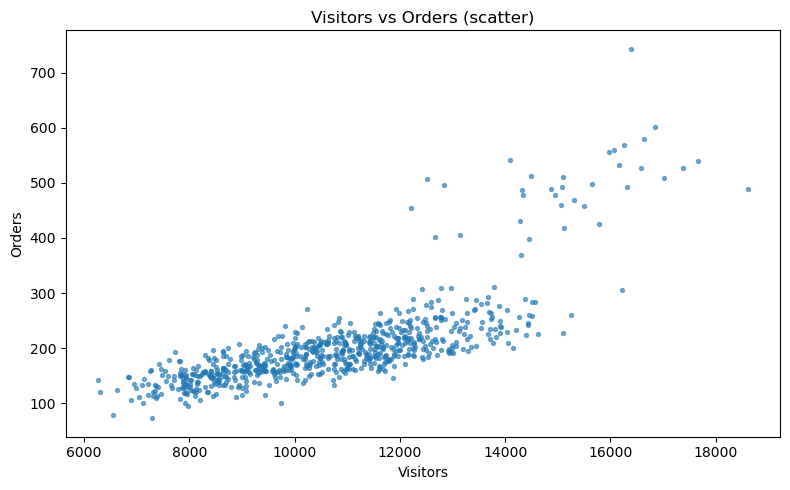

           days   mean_revenue  median_revenue  mean_orders  mean_visitors  \
festival   35.0  751190.987714       736711.93   497.085714   15255.285714   
baseline  695.0  226480.774144       222684.51   187.919424   10495.532374   

           mean_cr    mean_aov  rev_per_visitor  
festival  0.032689  1505.16200        49.334729  
baseline  0.017915  1203.77577        21.577821  
Revenue test: {'stat': 19.716239718903736, 'pvalue': 2.3843857656872255e-20}
CR test: {'stat': 21.034161797955583, 'pvalue': 1.6580857376722461e-21}

Percent lifts (festival vs baseline):
revenue_mean_lift_pct       231.679804
orders_mean_lift_pct        164.520667
cr_mean_lift_pct             82.466560
aov_mean_lift_pct            25.036742
rev_per_visitor_lift_pct    128.636286
dtype: float64
  top_category  mean_revenue_False  mean_revenue_True  mean_orders_False  \
0       beauty       229557.340962      769137.748571         192.365385   
1  electronics       231928.149185      679885.968333         191

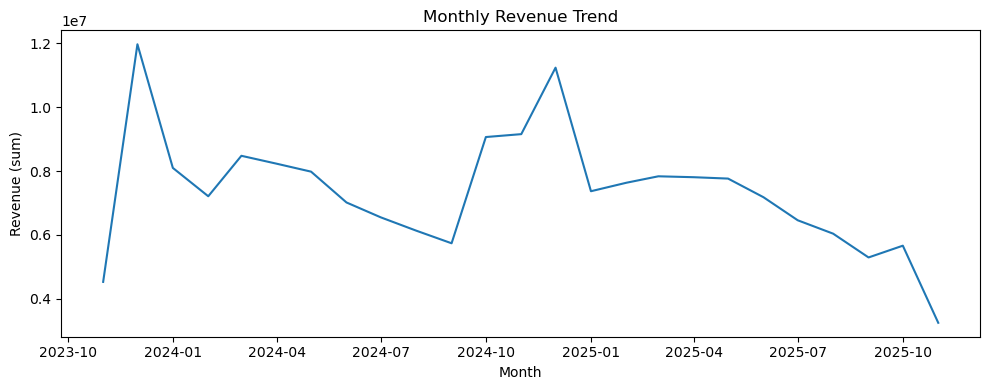

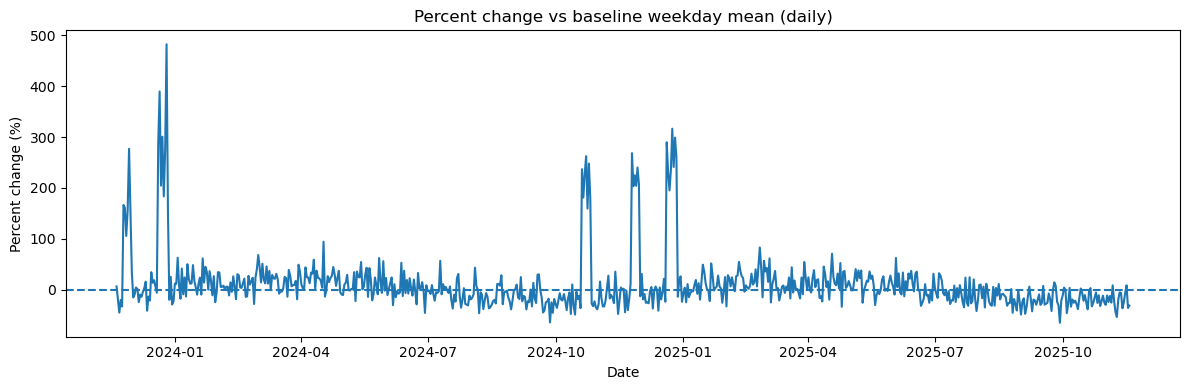

   festival_days  baseline_days  mean_daily_revenue_festival  \
0             35            695                751190.987714   

   mean_daily_revenue_baseline  revenue_lift_pct  orders_lift_pct  cr_lift_pct  
0                226480.774144        231.679804       164.520667     82.46656  

Saved figures and CSVs to \mnt\data\ecommerce_festival_analysis

Quick summary (auto-generated):
- Festival windows: [(datetime.datetime(2023, 11, 25, 0, 0), datetime.datetime(2023, 11, 30, 0, 0)), (datetime.datetime(2023, 12, 20, 0, 0), datetime.datetime(2023, 12, 27, 0, 0)), (datetime.datetime(2024, 10, 20, 0, 0), datetime.datetime(2024, 10, 26, 0, 0)), (datetime.datetime(2024, 11, 25, 0, 0), datetime.datetime(2024, 11, 30, 0, 0)), (datetime.datetime(2024, 12, 20, 0, 0), datetime.datetime(2024, 12, 27, 0, 0))]
- Festival days in dataset: 35, baseline days: 695
- Mean daily revenue during festival: 751190.99
- Mean daily revenue during baseline: 226480.77
- Revenue uplift (mean): 231.68%
- Revenue 

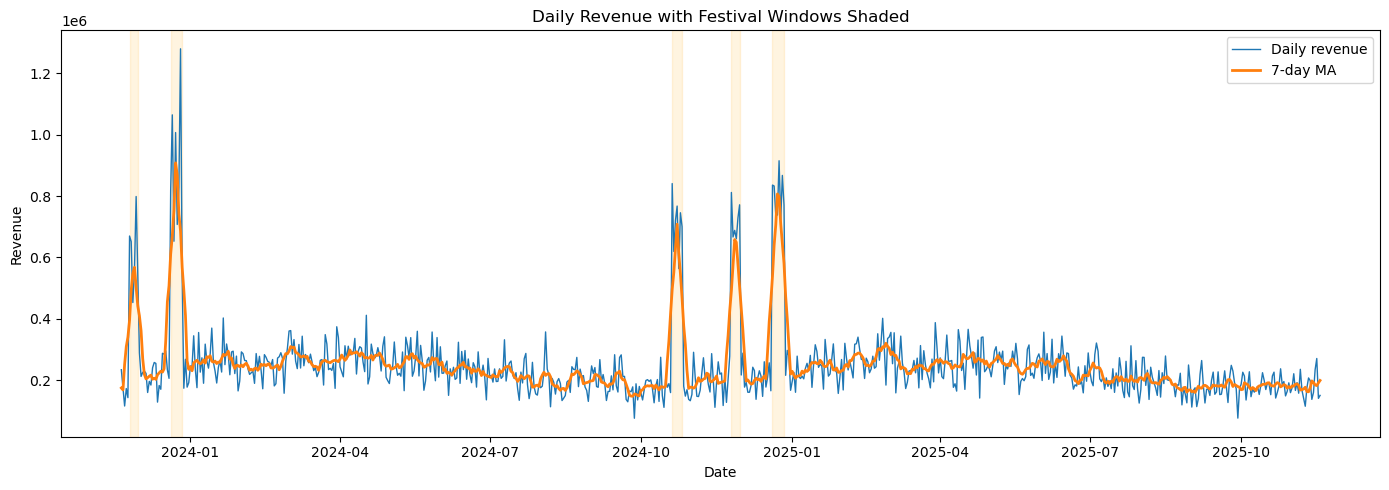

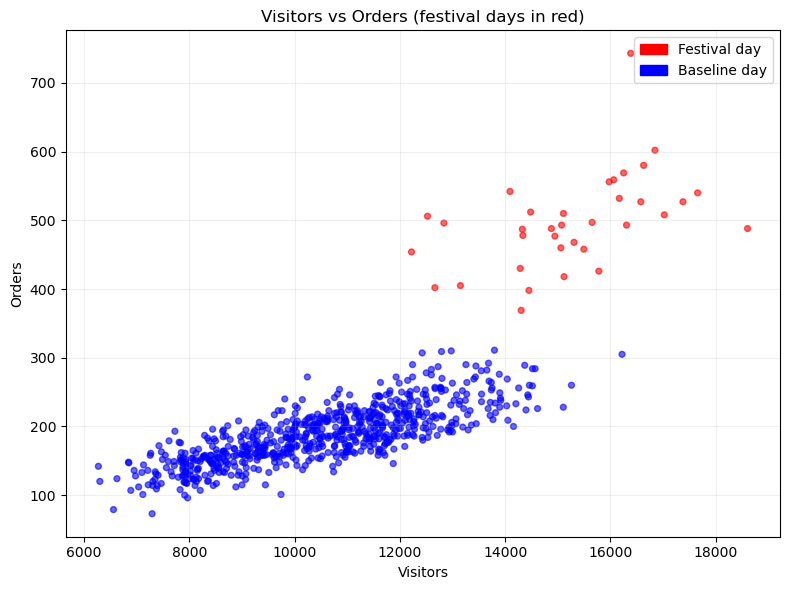

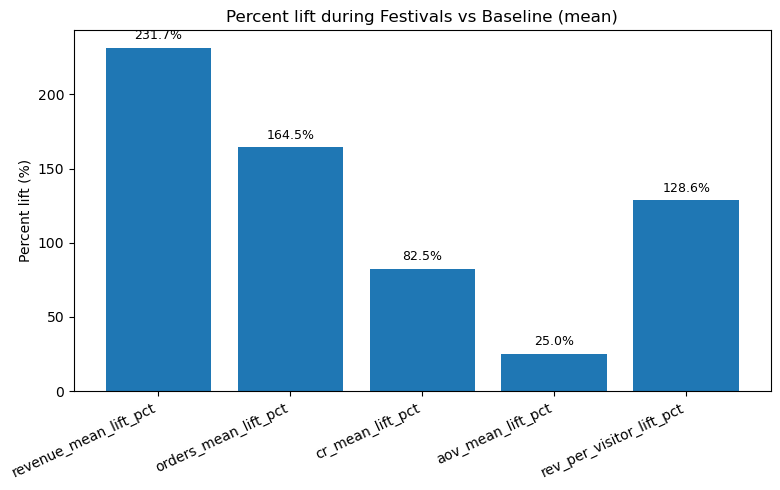

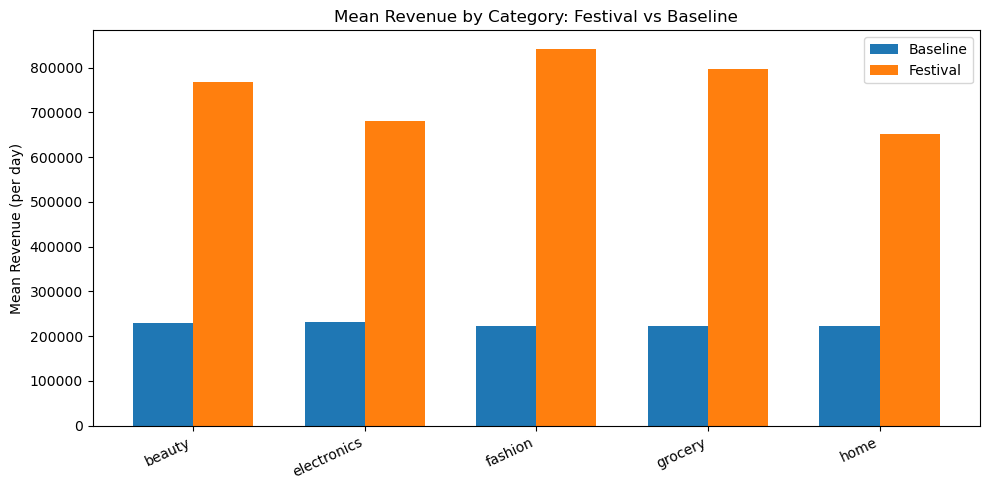

In [3]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pathlib import Path

output_dir = Path("/mnt/data/ecommerce_festival_analysis")
output_dir.mkdir(parents=True, exist_ok=True)

np.random.seed(42)

# Helper: try to import scipy for t-test; if not available, we'll use bootstrap
use_scipy = True
try:
    from scipy import stats
except Exception:
    use_scipy = False

# 1) Load CSV if provided, else simulate dataset
csv_path = Path("/mnt/data/ecommerce_data.csv")
if csv_path.exists():
    df = pd.read_csv(csv_path, parse_dates=["date"])
    print(f"Loaded dataset from {csv_path} with {len(df):,} rows.")
else:
    print("No CSV found at /mnt/data/ecommerce_data.csv — creating synthetic dataset (2 years daily)")
    start = datetime.today() - timedelta(days=730)
    dates = pd.date_range(start=start.date(), periods=730, freq="D")
    rows = []
    # Define festival windows (example) - you can replace dates later
    festival_windows = []
    for year_offset in [0, 1]:
        base_year = (start.year + year_offset)
        festival_windows.append((datetime(base_year, 10, 20), datetime(base_year, 10, 26)))  # Festival A
        festival_windows.append((datetime(base_year, 11, 25), datetime(base_year, 11, 30)))  # Festival B
        festival_windows.append((datetime(base_year, 12, 20), datetime(base_year, 12, 27)))  # Festival C
    # keep windows trimmed to the date range
    festival_windows = [(max(start, s), min(dates[-1].to_pydatetime(), e)) for s,e in festival_windows if e >= start and s <= dates[-1].to_pydatetime()]

    for d in dates:
        base_visitors = int(10000 + 2000*np.sin(2*np.pi*(d.timetuple().tm_yday)/365) + np.random.normal(0,800))
        if base_visitors < 1000:
            base_visitors = int(1000 + np.random.poisson(200))
        # FIX: compare dates (use d.date())
        is_festival = any([(d.date() >= s.date() and d.date() <= e.date()) for s,e in festival_windows])
        traffic_multiplier = 1.0 + (0.6 if is_festival else 0.0) + (0.15 if d.weekday() >=5 else 0.0) # weekends higher
        visitors = int(base_visitors * traffic_multiplier)
        conv_base = 0.018 + np.random.normal(0, 0.002)
        conv = conv_base * (1.8 if is_festival else 1.0)
        conv = max(0.005, min(conv, 0.15))
        orders = np.random.binomial(visitors, conv)
        aov = np.random.normal(1200, 150)
        if is_festival:
            aov *= 1.25 + np.random.normal(0,0.05)
        revenue = max(0, orders * aov)
        top_category = np.random.choice(["electronics","fashion","home","beauty","grocery"], p=[0.25,0.25,0.2,0.15,0.15])
        rows.append({
            "date": d.date(),
            "visitors": visitors,
            "orders": orders,
            "revenue": round(revenue,2),
            "aov": round(aov,2),
            "top_category": top_category,
            "is_festival": bool(is_festival)
        })
    df = pd.DataFrame(rows)
    df.to_csv(output_dir/"synthetic_ecommerce_data.csv", index=False)
    print(f"Synthetic dataset created with {len(df):,} rows and saved to {output_dir/'synthetic_ecommerce_data.csv'}")

# 2) Basic preprocessing & sanity checks
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)
for col in ['visitors','orders','revenue']:
    if df[col].isna().any():
        df[col] = df[col].fillna(0)

df['cr'] = df['orders'] / df['visitors']
df['rev_per_visitor'] = df['revenue'] / df['visitors']

display_df = df.head(8)
try:
    import ace_tools as tools
    tools.display_dataframe_to_user("Sample data (first 8 rows)", display_df)
except Exception:
    print(display_df)

# 3) Exploratory plots (matplotlib; one plot per figure)
plt.figure(figsize=(12,4))
plt.plot(df['date'], df['revenue'])
plt.title("Daily Revenue Time Series")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.tight_layout()
plt.savefig(output_dir/"daily_revenue.png")
plt.show()

df['rev_7d_ma'] = df['revenue'].rolling(7, center=True, min_periods=1).mean()
plt.figure(figsize=(12,4))
plt.plot(df['date'], df['rev_7d_ma'])
plt.title("7-day Rolling Average Revenue")
plt.xlabel("Date")
plt.ylabel("Revenue (7d MA)")
plt.tight_layout()
plt.savefig(output_dir/"revenue_7d_ma.png")
plt.show()

plt.figure(figsize=(8,5))
plt.scatter(df['visitors'], df['orders'], s=8, alpha=0.6)
plt.title("Visitors vs Orders (scatter)")
plt.xlabel("Visitors")
plt.ylabel("Orders")
plt.tight_layout()
plt.savefig(output_dir/"visitors_vs_orders.png")
plt.show()

# 4) Festival vs baseline comparison
festival_days = df[df['is_festival']]
baseline_days = df[~df['is_festival']]

metrics = {}
for name, group in [("festival", festival_days), ("baseline", baseline_days)]:
    metrics[name] = {
        "days": len(group),
        "mean_revenue": group['revenue'].mean(),
        "median_revenue": group['revenue'].median(),
        "mean_orders": group['orders'].mean(),
        "mean_visitors": group['visitors'].mean(),
        "mean_cr": group['cr'].mean(),
        "mean_aov": group['aov'].mean(),
        "rev_per_visitor": group['rev_per_visitor'].mean()
    }

metrics_df = pd.DataFrame(metrics).T
try:
    tools.display_dataframe_to_user("Festival vs Baseline aggregated metrics", metrics_df)
except Exception:
    print(metrics_df)

# 5) Statistical testing: revenue and CR
def bootstrap_mean_diff(a, b, n_boot=5000):
    a = np.array(a)
    b = np.array(b)
    obs_diff = a.mean() - b.mean()
    rng = np.random.default_rng(123)
    diffs = []
    for _ in range(n_boot):
        s1 = rng.choice(a, size=len(a), replace=True)
        s2 = rng.choice(b, size=len(b), replace=True)
        diffs.append(s1.mean() - s2.mean())
    diffs = np.array(diffs)
    p_two = np.mean(np.abs(diffs) >= abs(obs_diff))
    ci_low = np.percentile(diffs, 2.5)
    ci_high = np.percentile(diffs, 97.5)
    return {"obs_diff": obs_diff, "p_value_boot": p_two, "ci": (ci_low, ci_high)}

if use_scipy:
    t_revenue = stats.ttest_ind(festival_days['revenue'], baseline_days['revenue'], equal_var=False, nan_policy='omit')
    t_cr = stats.ttest_ind(festival_days['cr'], baseline_days['cr'], equal_var=False, nan_policy='omit')
    revenue_test = {"stat": t_revenue.statistic, "pvalue": t_revenue.pvalue}
    cr_test = {"stat": t_cr.statistic, "pvalue": t_cr.pvalue}
else:
    revenue_test = bootstrap_mean_diff(festival_days['revenue'], baseline_days['revenue'])
    cr_test = bootstrap_mean_diff(festival_days['cr'], baseline_days['cr'])

print("Revenue test:", revenue_test)
print("CR test:", cr_test)

# 6) Percent lift calculations (festival vs baseline)
def percent_lift(f_est, f_base):
    return (f_est - f_base) / f_base * 100.0 if f_base!=0 else np.nan

pct_lifts = {
    "revenue_mean_lift_pct": percent_lift(metrics['festival']['mean_revenue'], metrics['baseline']['mean_revenue']),
    "orders_mean_lift_pct": percent_lift(metrics['festival']['mean_orders'], metrics['baseline']['mean_orders']),
    "cr_mean_lift_pct": percent_lift(metrics['festival']['mean_cr'], metrics['baseline']['mean_cr']),
    "aov_mean_lift_pct": percent_lift(metrics['festival']['mean_aov'], metrics['baseline']['mean_aov']),
    "rev_per_visitor_lift_pct": percent_lift(metrics['festival']['rev_per_visitor'], metrics['baseline']['rev_per_visitor']),
}
pd.DataFrame.from_dict(pct_lifts, orient='index', columns=["pct_lift"]).to_csv(output_dir/"percent_lifts.csv")
print("\nPercent lifts (festival vs baseline):")
print(pd.Series(pct_lifts))

# 7) Segmented analysis by top_category
seg = df.groupby(['top_category','is_festival']).agg(days=('date','count'),
                                                     mean_revenue=('revenue','mean'),
                                                     mean_orders=('orders','mean'),
                                                     mean_cr=('cr','mean')).reset_index()
pivot = seg.pivot(index='top_category', columns='is_festival', values=['mean_revenue','mean_orders','mean_cr'])
pivot.columns = ['_'.join([str(c) for c in col]).strip() for col in pivot.columns.values]
pivot = pivot.reset_index()
try:
    tools.display_dataframe_to_user("Segmented festival vs baseline (by top category)", pivot)
except Exception:
    print(pivot)

# 8) Time series decomposition (simple: weekly and monthly)
df['weekday'] = df['date'].dt.day_name()
weekday_avg = df.groupby('weekday').agg(mean_revenue=('revenue','mean')).reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
).reset_index()
try:
    tools.display_dataframe_to_user("Average revenue by weekday", weekday_avg)
except Exception:
    print(weekday_avg)

df['month'] = df['date'].dt.to_period('M').dt.to_timestamp()
monthly = df.groupby('month').agg(month_revenue=('revenue','sum')).reset_index()
plt.figure(figsize=(10,4))
plt.plot(monthly['month'], monthly['month_revenue'])
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue (sum)")
plt.tight_layout()
plt.savefig(output_dir/"monthly_revenue_trend.png")
plt.show()

# 9) Bootstraped daily uplift visualization: percent change from baseline rolling
baseline_weekday = baseline_days.groupby(baseline_days['date'].dt.weekday).agg(mean_rev=('revenue','mean')).to_dict()['mean_rev']
df['baseline_weekday_mean'] = df['date'].dt.weekday.map(baseline_weekday)
df['pct_change_vs_baseline_weekday'] = (df['revenue'] - df['baseline_weekday_mean']) / df['baseline_weekday_mean'] * 100.0

plt.figure(figsize=(12,4))
plt.plot(df['date'], df['pct_change_vs_baseline_weekday'])
plt.title("Percent change vs baseline weekday mean (daily)")
plt.xlabel("Date")
plt.ylabel("Percent change (%)")
plt.axhline(0, linestyle='--')
plt.tight_layout()
plt.savefig(output_dir/"pct_change_vs_baseline.png")
plt.show()

# 10) Summary results saved
summary = {
    "festival_days": len(festival_days),
    "baseline_days": len(baseline_days),
    "mean_daily_revenue_festival": metrics['festival']['mean_revenue'],
    "mean_daily_revenue_baseline": metrics['baseline']['mean_revenue'],
    "revenue_lift_pct": pct_lifts['revenue_mean_lift_pct'],
    "orders_lift_pct": pct_lifts['orders_mean_lift_pct'],
    "cr_lift_pct": pct_lifts['cr_mean_lift_pct'],
}
summary_df = pd.DataFrame([summary])
summary_df.to_csv(output_dir/"summary_results.csv", index=False)
try:
    tools.display_dataframe_to_user("Summary results", summary_df)
except Exception:
    print(summary_df)

print(f"\nSaved figures and CSVs to {output_dir}")

df.to_csv(output_dir/"processed_daily_data.csv", index=False)
pivot.to_csv(output_dir/"segment_festival_vs_baseline.csv", index=False)

print("\nQuick summary (auto-generated):")
print(f"- Festival windows: {festival_windows}")
print(f"- Festival days in dataset: {len(festival_days)}, baseline days: {len(baseline_days)}")
print(f"- Mean daily revenue during festival: {metrics['festival']['mean_revenue']:.2f}")
print(f"- Mean daily revenue during baseline: {metrics['baseline']['mean_revenue']:.2f}")
print(f"- Revenue uplift (mean): {pct_lifts['revenue_mean_lift_pct']:.2f}%")
if use_scipy:
    print(f"- Revenue t-test p-value: {revenue_test['pvalue']:.4f}")
else:
    print(f"- Revenue bootstrap p-value: {revenue_test['p_value_boot']:.4f}")

print("\nFiles saved:")
for f in sorted(output_dir.glob("*")):
    print("-", f.name)



plt.figure(figsize=(14,5))
plt.plot(df['date'], df['revenue'], label='Daily revenue', linewidth=1)
plt.plot(df['date'], df['rev_7d_ma'], label='7-day MA', linewidth=2)
# highlight festival days as vertical shading
for s,e in festival_windows:
    s_dt = pd.to_datetime(s).date()
    e_dt = pd.to_datetime(e).date()
    plt.axvspan(s_dt, e_dt, alpha=0.12, color='orange')
plt.title("Daily Revenue with Festival Windows Shaded")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.tight_layout()
plt.savefig(output_dir/"line_daily_revenue_with_festivals.png")
plt.show()

# ---------- 2) Scatter plot: Visitors vs Orders (colored by festival) ----------
plt.figure(figsize=(8,6))
colors = df['is_festival'].map({True: 'red', False: 'blue'})
plt.scatter(df['visitors'], df['orders'], s=18, alpha=0.6, c=colors)
# add small legend
import matplotlib.patches as mpatches
fest_patch = mpatches.Patch(color='red', label='Festival day')
base_patch = mpatches.Patch(color='blue', label='Baseline day')
plt.legend(handles=[fest_patch, base_patch])
plt.title("Visitors vs Orders (festival days in red)")
plt.xlabel("Visitors")
plt.ylabel("Orders")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig(output_dir/"scatter_visitors_vs_orders_colored.png")
plt.show()

# ---------- 3) Bar plot: Percent lifts (festival vs baseline) ----------
# Use the pct_lifts dict computed earlier
lifts_df = pd.DataFrame.from_dict(pct_lifts, orient='index', columns=['pct_lift']).reset_index()
lifts_df = lifts_df.rename(columns={'index':'metric'})
plt.figure(figsize=(8,5))
bars = plt.bar(lifts_df['metric'], lifts_df['pct_lift'])
plt.title("Percent lift during Festivals vs Baseline (mean)")
plt.ylabel("Percent lift (%)")
plt.xticks(rotation=25, ha='right')
# annotate values on bars
for rect in bars:
    h = rect.get_height()
    plt.annotate(f"{h:.1f}%", xy=(rect.get_x() + rect.get_width() / 2, h),
                 xytext=(0, 4), textcoords="offset points", ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.savefig(output_dir/"bar_percent_lifts.png")
plt.show()

seg_rev = pivot[['top_category']].copy()
# attempt to read festival & baseline columns (booleans may be True/False)
cols = [c for c in pivot.columns if 'mean_revenue' in c]
# if both present, build grouped bar; else skip with message
if len(cols) >= 2:
    # find which is festival (True) and baseline (False)
    # columns might be like 'mean_revenue_False' and 'mean_revenue_True'
    col_base = [c for c in cols if c.endswith('False') or c.endswith('_0') or c.endswith("0") ]
    col_fest = [c for c in cols if c.endswith('True') or c.endswith('_1') or c.endswith("1") ]
    if col_base and col_fest:
        base_col = col_base[0]; fest_col = col_fest[0]
    else:
        # fallback: assume cols[0]=baseline, cols[1]=festival
        base_col, fest_col = cols[0], cols[1]
    x = np.arange(len(pivot))
    width = 0.35
    plt.figure(figsize=(10,5))
    plt.bar(x - width/2, pivot[base_col].fillna(0), width, label='Baseline')
    plt.bar(x + width/2, pivot[fest_col].fillna(0), width, label='Festival')
    plt.xticks(x, pivot['top_category'], rotation=25, ha='right')
    plt.ylabel("Mean Revenue (per day)")
    plt.title("Mean Revenue by Category: Festival vs Baseline")
    plt.legend()
    plt.tight_layout()
    plt.savefig(output_dir/"groupedbar_segment_revenue.png")
    plt.show()
else:
    print("Not enough pivot revenue columns to draw grouped bar (need festival & baseline). Pivot columns:", pivot.columns.tolist())



